In [1]:
import pandas as pd
import plotly.express as px

In [2]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import SentenceTransformerEmbeddings
from langchain_community.chat_models import ChatOllama



In [3]:
df = pd.read_csv("employee_data.csv")  # replace with your file
df.head()


,ID,Gender,Experience (Years),Position,Salary
0,1,F,4,DevOps Engineer,109976
1,2,M,6,DevOps Engineer,120088
2,3,M,17,Web Developer,181301
3,4,M,7,Systems Administrator,77530
4,5,F,13,Systems Administrator,152397


In [4]:
df_clean = df.copy()

for col in df_clean.columns:
    if df_clean[col].dtype in ["float64", "int64"]:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)
    else:
        df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

df_clean.head()


C:\Users\91942\AppData\Local\Temp\ipykernel_56628\4183397251.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(df_clean[col].median(), inplace=True)
C:\Users\91942\AppData\Local\Temp\ipykernel_56628\4183397251.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

,ID,Gender,Experience (Years),Position,Salary
0,1,F,4,DevOps Engineer,109976
1,2,M,6,DevOps Engineer,120088
2,3,M,17,Web Developer,181301
3,4,M,7,Systems Administrator,77530
4,5,F,13,Systems Administrator,152397


In [5]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  400 non-null    int64 
 1   Gender              400 non-null    object
 2   Experience (Years)  400 non-null    int64 
 3   Position            400 non-null    object
 4   Salary              400 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 15.8+ KB


In [6]:
print("Shape:", df_clean.shape)
print("\nDtypes:\n", df_clean.dtypes)
print("\nMissing values per column:\n", df_clean.isnull().sum())

df_clean.describe(include="all")


Shape: (400, 5)

Dtypes:
 ID                     int64
Gender                object
Experience (Years)     int64
Position              object
Salary                 int64
dtype: object

Missing values per column:
 ID                    0
Gender                0
Experience (Years)    0
Position              0
Salary                0
dtype: int64


,ID,Gender,Experience (Years),Position,Salary
count,400.000000,400,400.000000,400,400.00000
unique,NaN,2,NaN,11,NaN
top,NaN,M,NaN,Web Developer,NaN
freq,NaN,202,NaN,43,NaN
mean,200.500000,NaN,9.670000,NaN,131701.19750
std,115.614301,NaN,6.101571,NaN,43351.50899
min,1.000000,NaN,0.000000,NaN,43643.00000
25%,100.750000,NaN,4.000000,NaN,100484.75000
50%,200.500000,NaN,10.000000,NaN,128561.50000
75%,300.250000,NaN,15.000000,NaN,157735.00000


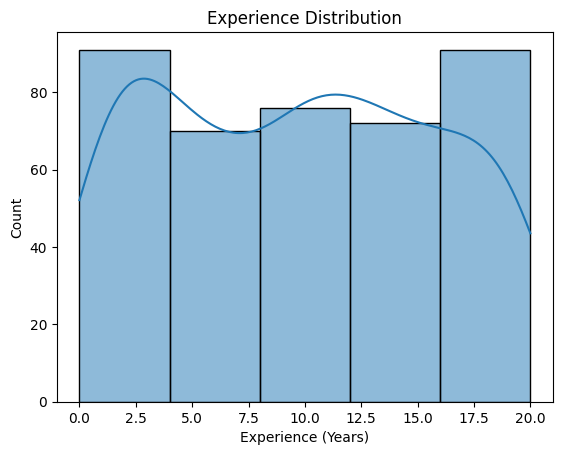

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_clean["Experience (Years)"], bins=5, kde=True)
plt.title("Experience Distribution")
plt.show()



In [8]:
df.columns

Index(['ID', 'Gender', 'Experience (Years)', 'Position', 'Salary'], dtype='object')

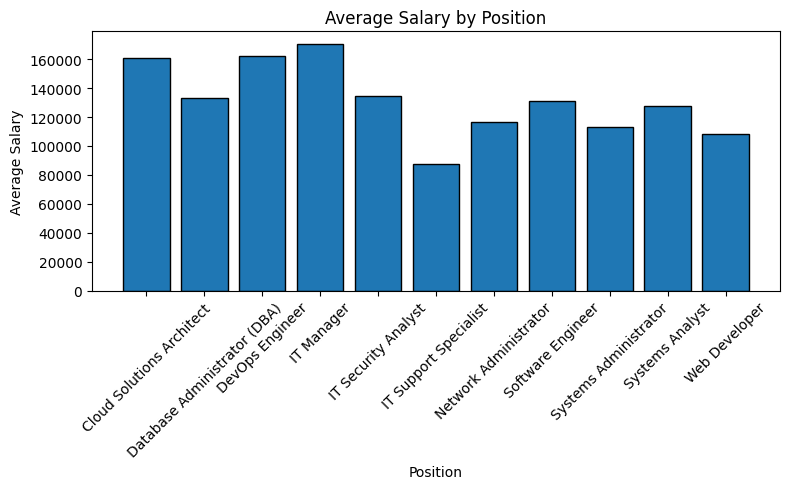

In [9]:
import matplotlib.pyplot as plt

avg_salary = df_clean.groupby("Position")["Salary"].mean().reset_index()

plt.figure(figsize=(8,5))
plt.bar(avg_salary["Position"], avg_salary["Salary"], edgecolor="black")

plt.title("Average Salary by Position")
plt.xlabel("Position")
plt.ylabel("Average Salary")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



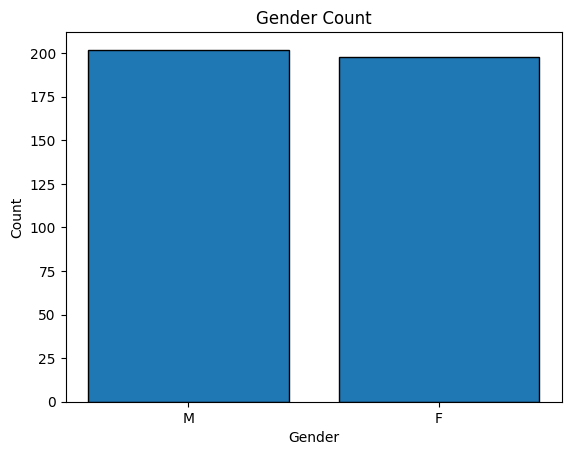

In [10]:
attrition_count = df_clean["Gender"].value_counts().reset_index()
attrition_count.columns = ["Gender", "Count"]

import matplotlib.pyplot as plt

plt.bar(attrition_count["Gender"], attrition_count["Count"], edgecolor="black")
plt.title("Gender Count")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()


In [11]:
from langchain_core.embeddings import Embeddings
from sentence_transformers import SentenceTransformer

class LocalEmbeddings(Embeddings):
    def __init__(self, model_name: str = "sentence-transformers/all-MiniLM-L6-v2"):
        self.model = SentenceTransformer(model_name)

    def embed_documents(self, texts):
        return self.model.encode(texts).tolist()

    def embed_query(self, text):
        return self.model.encode([text])[0].tolist()

embed_model = LocalEmbeddings()



In [12]:
data_text = df_clean.to_markdown(index=False)

splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=100)
chunks = splitter.split_text(data_text)
len(chunks)


51

In [13]:
vectorstore = Chroma.from_texts(
    texts=chunks,
    embedding=embed_model,
    collection_name="employee_hr_rag"
)

retriever = vectorstore.as_retriever(search_kwargs={"k": 4})


In [14]:
llm = ChatOllama(model="llama3.2", temperature=0.2)
resp = llm.invoke("Explain what HR analytics is in one sentence.")
print(resp.content)


C:\Users\91942\AppData\Local\Temp\ipykernel_56628\3762445209.py:1: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the `langchain-ollama package and should be used instead. To use it run `pip install -U `langchain-ollama` and import as `from `langchain_ollama import ChatOllama``.
  llm = ChatOllama(model="llama3.2", temperature=0.2)


HR analytics refers to the use of data analysis and statistical methods to measure, analyze, and improve human resources (HR) functions, such as talent management, employee engagement, benefits administration, and performance evaluation, to inform strategic business decisions.


In [15]:
chain = retriever | llm


In [16]:
q1 = "Which department seems to have the highest average salary?"
print(chain.invoke(q1))

q2 = "Does attrition appear in any particular department or role?"
print(chain.invoke(q2))

q3 = "What can you infer about employee experience and salary in this dataset?"
print(chain.invoke(q3))


NotImplementedError: Unsupported message type: <class 'langchain_core.documents.base.Document'>
For troubleshooting, visit: https://docs.langchain.com/oss/python/langchain/errors/MESSAGE_COERCION_FAILURE 

In [ ]:
sample = df_clean.head(10).to_markdown(index=False)

prompt = f"""
You are an HR analytics expert.

Using the dataset sample below, provide:
1. Overall summary of the employee data
2. 3–5 key insights about departments, salary, experience, and attrition
3. Any risks or red flags related to attrition or performance
4. 5 actionable recommendations for HR
5. 3 follow-up questions for deeper HR analysis

Dataset:
{sample}
"""

report = llm.invoke(prompt)
print(report.content)


**Overall Summary of Employee Data**

The dataset consists of 10 employees with diverse characteristics. The majority of employees are male (7/10), and the average experience is around 8 years, with a range of 2-17 years. The salary distribution shows that most employees earn between $75,000 to $160,000 per year.

**Key Insights**

1. **Departmental Distribution**: The dataset reveals an uneven distribution of departments, with DevOps Engineers and Systems Administrators being the most represented (3/5). Web Developers are underrepresented, which might indicate a need for recruitment or training programs.
2. **Salary Variance**: There is a significant salary variance within each department. For instance, the average salary for DevOps Engineers is $110,000, while the highest-paid employee in this category earns $120,000. This suggests that there may be opportunities to optimize salaries and benefits to retain top talent.
3. **Experience Distribution**: The experience distribution shows 